# Principal Component Analysis

In [105]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
from great_tables import loc, style
from itertools import accumulate

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from scipy.stats import loguniform

sns.set_context('notebook')
sns.set_style('white')

PCA is a dimensionality reduction technique. The idea is to transform the data to a new coordinate space where the data lies along the directions of highest variance.  The principal components are then the orthogonal set of unit vectors spanning this space, where the criterium for finding this space is minimizing the perpendicular distance from points to the line spanned by each of the vectors.

A common way to use this is to take multidimensional data and extract the first two principal components to be able to plot the data in a 2D graph.

It also has use in domains where there may be much redundancy in input data, such as:
- Facial Recognition
- Pattern finding
- Image compression

Here we first use PCA on a height/weight dataset for illustration, then use PCA on a facial recognition dataset to find so called 'eigenfaces'.

In [144]:
## HELPER FUNCTION
def plot_explained_variance(pca, threshold=None):
    # This function graphs the accumulated explained variance ratio for a fitted PCA object.
    acc = [*accumulate(pca.explained_variance_ratio_)]
    fig, ax = plt.subplots(1, figsize=(50, 20))
    ax.stackplot(range(pca.n_components_), acc)
    ax.scatter(range(pca.n_components_), acc, color='black')
    if threshold:
        ax.plot([0, pca.n_components_], [threshold, threshold], 'k--')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, pca.n_components_-1)
    ax.tick_params(axis='both', labelsize=36)
    ax.set_xlabel('N Components', fontsize=48)
    ax.set_ylabel('Accumulated explained variance', fontsize=48)
    plt.tight_layout()
    plt.show()

## PCA Illustration

At this point the basic way of working with dataframes and sklearn is clear, so there will be fewer explanatory sections.

What is important to know here:
- Scaling is important for PCA
- The data below contains two columns for weight, one in pounds and one in kilogram. These differ only by a scalar factor and are thus linearly dependent.

In [41]:
df = pl.read_csv("./data/HeightsWeights.csv")
df.head()

Index,Height(Inches),Weight(Pounds),Weight(Kilograms)
i64,f64,f64,f64
1,65.78331,112.9925,51.253062
2,71.51521,136.4873,61.910233
3,69.39874,153.0269,69.412546
4,68.2166,142.3354,64.562914
5,67.78781,144.2971,65.452735


In [42]:
scaler = StandardScaler()
df_scaled = pl.DataFrame(scaler.fit_transform(df.to_numpy()), df.columns).drop("Index")
df_scaled.head()

Height(Inches),Weight(Pounds),Weight(Kilograms)
f64,f64,f64
-1.162051,-1.208072,-1.208072
1.852136,0.806805,0.806805
0.739165,2.225214,2.225214
0.117523,1.308328,1.308328
-0.107961,1.476561,1.476561


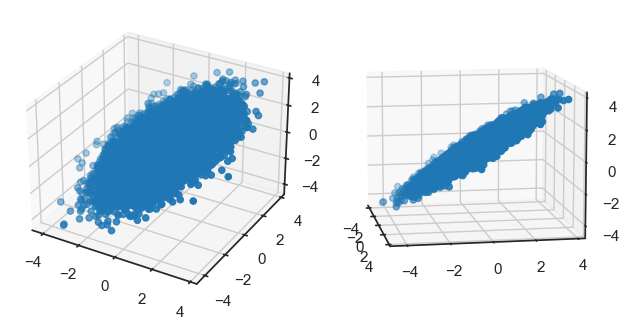

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
xs, ys, zs = [df_scaled[attr] for attr in df_scaled.columns]
ax1.scatter(xs, ys, zs)

ax2 = fig.add_subplot(122, projection='3d')
xs, ys, zs = [df_scaled[attr] for attr in df_scaled.columns]
ax2.view_init(elev=10, azim=-10)
ax2.scatter(xs, ys, zs)

plt.tight_layout()
plt.show()

The data lies in a plane, to be expected with two linearly dependent features. This is illustrated even better with a pairplot, after scaling the two features are exaclty the same.

This is even more clear by showing the correlation matrix, which give a perfect correlation between the two columns.

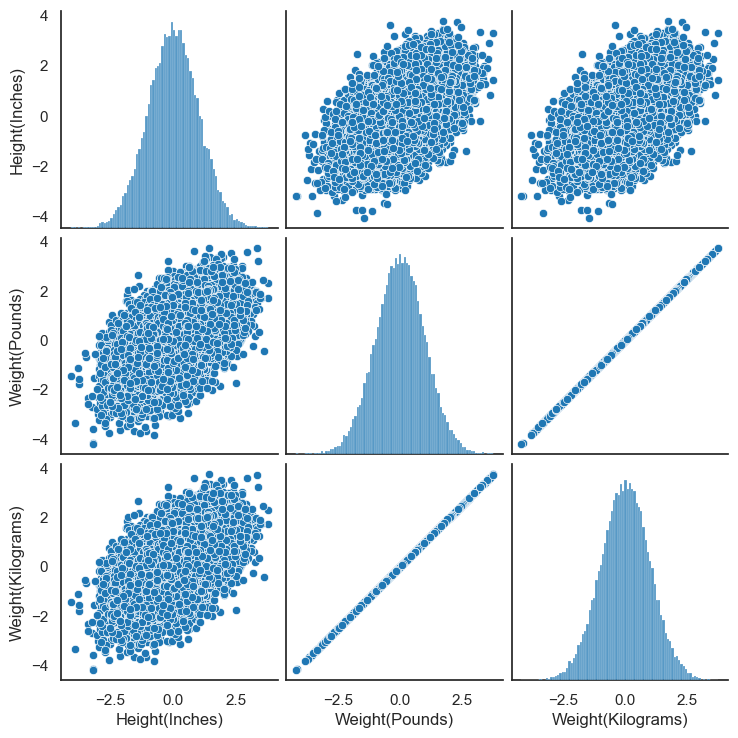

In [44]:
sns.pairplot(df_scaled.to_pandas())
plt.show()

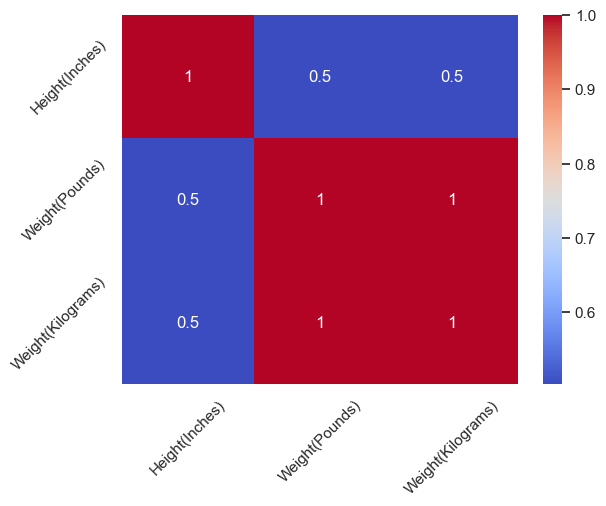

In [45]:
ax = sns.heatmap(
    df_scaled.corr(), 
    cmap="coolwarm", 
    annot=True, 
    xticklabels=df_scaled.columns, 
    yticklabels=df_scaled.columns)
ax.tick_params(labelrotation=45)

Let's now see what PC makes of this. We can project the original dataset onto the components found with PCA and inspect the resulting dataframe.

In [46]:
pca = PCA()
df_pca = pl.DataFrame(pca.fit_transform(df_scaled), df_scaled.columns)
df_pca.head()

Height(Inches),Weight(Pounds),Weight(Kilograms)
f64,f64,f64
-2.051774,-0.243847,-1.4370e-16
1.866218,1.117813,4.7944e-16
3.133436,-0.79442,7.5119e-16
1.696186,-0.748473,-1.2670e-16
1.803402,-1.058234,2.2935e-16


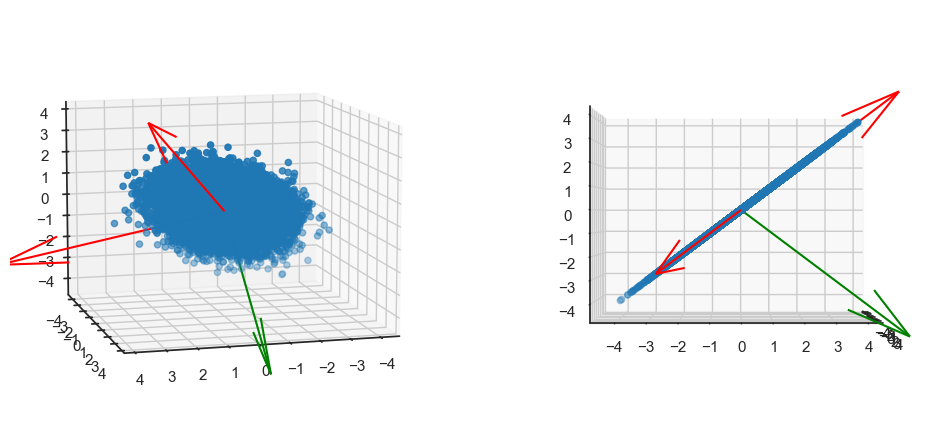

red component accounts for 78.98% of explained variance
red component accounts for 21.02% of explained variance
green component accounts for 0.00% of explained variance


In [47]:
colors = ['red', 'red', 'green']

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121, projection='3d')
xs, ys, zs = [df_scaled[attr] for attr in df_scaled.columns]
ax1.view_init(elev=10, azim=75)
ax1.scatter(xs, ys, zs)

for component, color in zip(pca.components_, colors):
    ax1.quiver(*[0, 0, 0], *(8 * component), color=color)

    
ax2 = fig.add_subplot(122, projection='3d')
xs, ys, zs = [df_scaled[attr] for attr in df_scaled.columns]
ax2.view_init(elev=0, azim=0)
ax2.scatter(xs, ys, zs)

for component, color in zip(pca.components_, colors):
    ax2.quiver(*[0, 0, 0], *(8 * component), color=color)

plt.show()

for color, ev in zip(colors, pca.explained_variance_ratio_):
    print(f'{color} component accounts for {ev * 100:.2f}% of explained variance')

The full varianbce of the data can be explained with just two components, the third component is redundant.

After the PCA transformation we can again plot the pairs and the correlation. From this we can see that the components were successfully decorrelated.

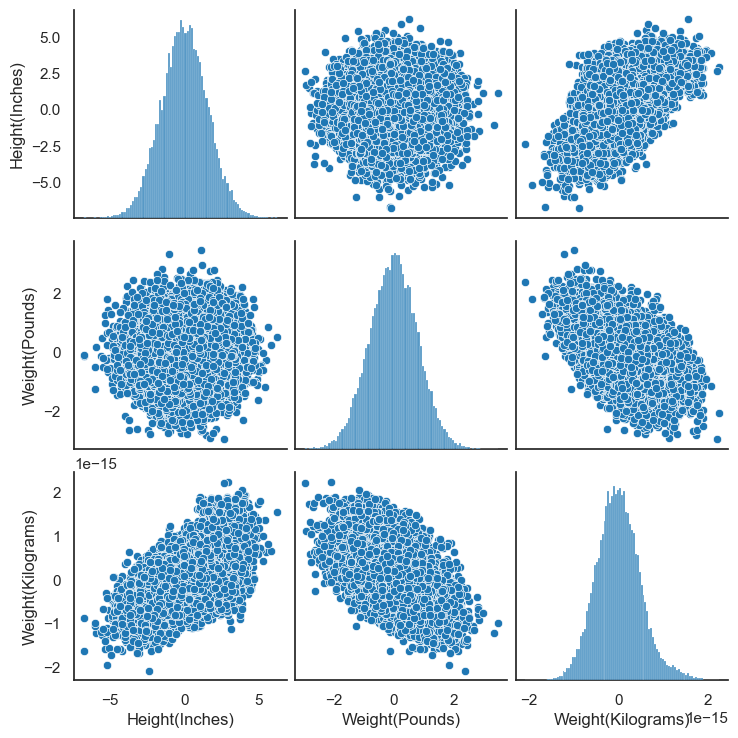

In [48]:
sns.pairplot(df_pca.to_pandas())
plt.show()

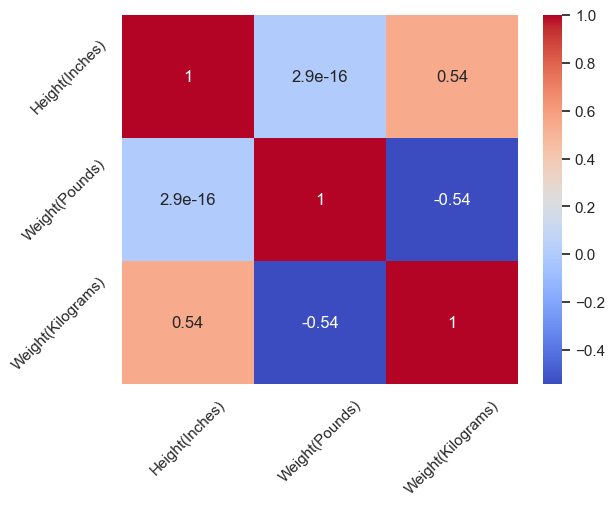

In [49]:
ax = sns.heatmap(
    df_pca.corr(), 
    cmap="coolwarm", 
    annot=True, 
    xticklabels=df_scaled.columns, 
    yticklabels=df_scaled.columns)
ax.tick_params(labelrotation=45)

Using the result of the PCA, we can determine a threshold for the variance below which we want to keep our data. This corresponds to keeping the first n components where the sum over those n components explains a certain amount of variance. A common value for this is 95%.

In this case we can just keep the first two components.

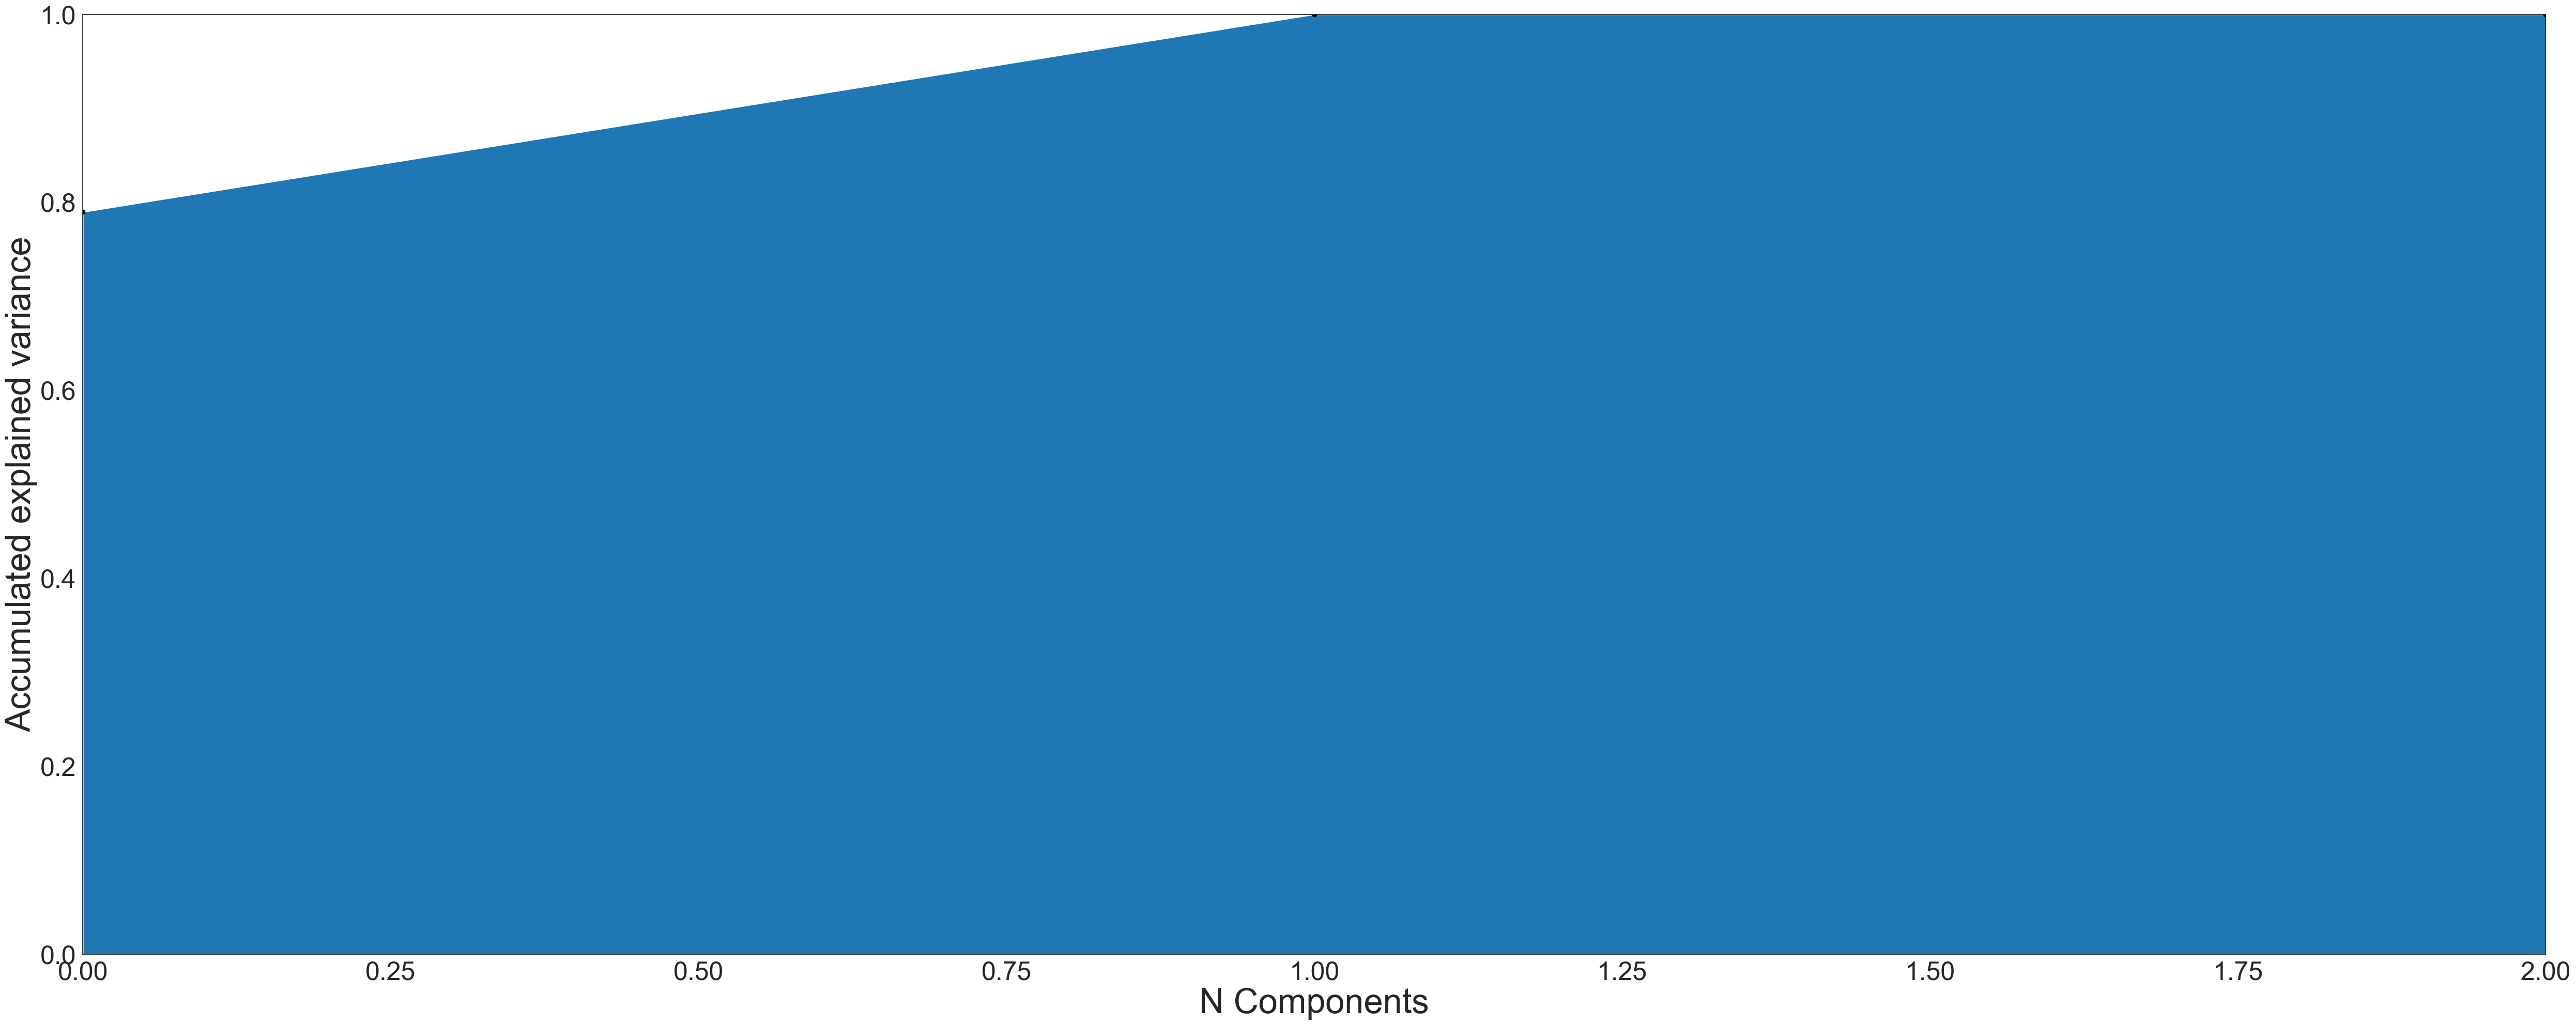

In [50]:
plot_explained_variance(pca)

In [51]:
# Set a threshold
threshold = 0.99
# Search through the cumulative sum of the variance to find at which index the variance threshold is exceeded
cum_var = np.cumsum(pca.explained_variance_ratio_)
k = np.searchsorted(cum_var, threshold) + 1
# Select only the minimal amount of columns to keep
df_pca = df_pca.select(df_pca.columns[:k])
df_pca.head()

Height(Inches),Weight(Pounds)
f64,f64
-2.051774,-0.243847
1.866218,1.117813
3.133436,-0.79442
1.696186,-0.748473
1.803402,-1.058234


## Facial Recognition PCA

A facial recognition system can encode facial image data as we would encode an image normally, an nxm matrix of pixels. But when we flatten this image into a vector, we can perform PCA and extract the components that make up the most variance in these images of faces. The resulting components are called 'Eigenfaces' (after the eigenvalues and eigenvectors that PCA finds).

In [52]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4, data_home="./data")

In [73]:
from collections import Counter
Counter(np.array(lfw_people.target_names)[lfw_people.target].tolist())

Counter({'George W Bush': 530,
         'Colin Powell': 236,
         'Tony Blair': 144,
         'Donald Rumsfeld': 121,
         'Gerhard Schroeder': 109,
         'Ariel Sharon': 77,
         'Hugo Chavez': 71})

In [53]:
# introspect the images arrays to find the shapes (for plotting)
N, h, w = lfw_people.images.shape
target_names = lfw_people.target_names

In [54]:
y = lfw_people.target
X = lfw_people.data
n_features = X.shape[1]

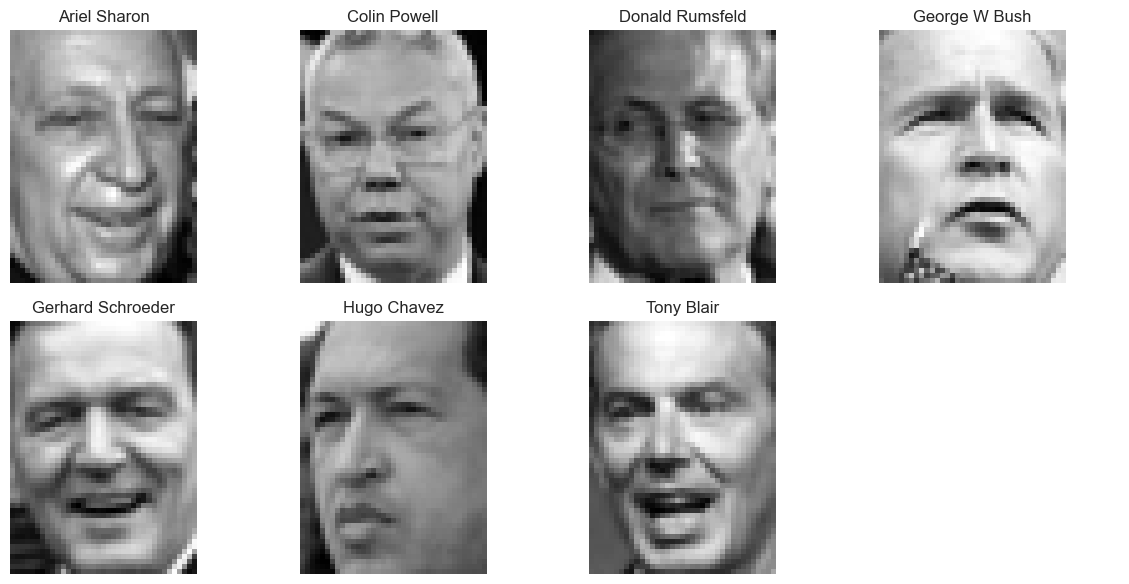

In [55]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for ax, person in zip(axes, np.unique(lfw_people.target)):
    idx = np.argmax(lfw_people.target == person)
    ax.imshow(lfw_people.images[idx], cmap="gray")
    ax.set_title(lfw_people.target_names[person])
    ax.axis("off")

# hide the unused 8th subplot
axes[-1].axis("off")

plt.tight_layout()
plt.show()

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [114]:
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1)
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train, y_train)

In [115]:
y_pred = clf.predict(X_test)

Text(47.24999999999999, 0.5, 'Truth Value')

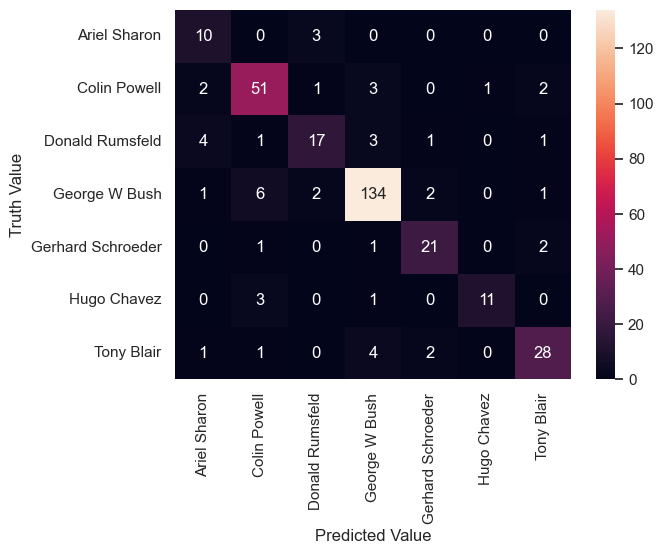

In [116]:
hmap = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    xticklabels=lfw_people.target_names,
    yticklabels=lfw_people.target_names,
    fmt='g'
)
hmap.set_xlabel('Predicted Value')
hmap.set_ylabel('Truth Value')

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.77      0.65        13
           1       0.81      0.85      0.83        60
           2       0.74      0.63      0.68        27
           3       0.92      0.92      0.92       146
           4       0.81      0.84      0.82        25
           5       0.92      0.73      0.81        15
           6       0.82      0.78      0.80        36

    accuracy                           0.84       322
   macro avg       0.80      0.79      0.79       322
weighted avg       0.85      0.84      0.85       322



This is actually already quite good. But we can do better by first reducing the dimensionality to more distinctive features.

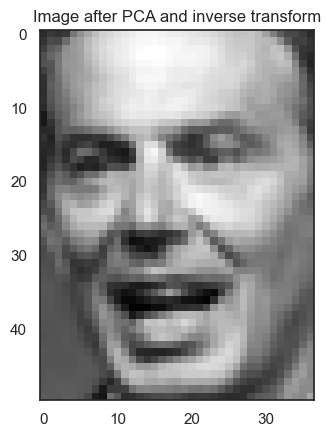

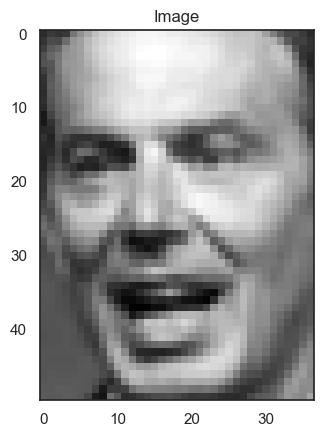

In [76]:
pca = PCA(svd_solver='full', whiten=True).fit(X_train) 
Xhat=pca.transform(X[1,:].reshape(1, -1))
plt.imshow(pca.inverse_transform(Xhat).reshape(h, w), cmap='gray')
plt.title("Image after PCA and inverse transform"  ) 
plt.show()
plt.imshow(lfw_people.images[1],cmap='gray')
plt.title("Image")
plt.show()

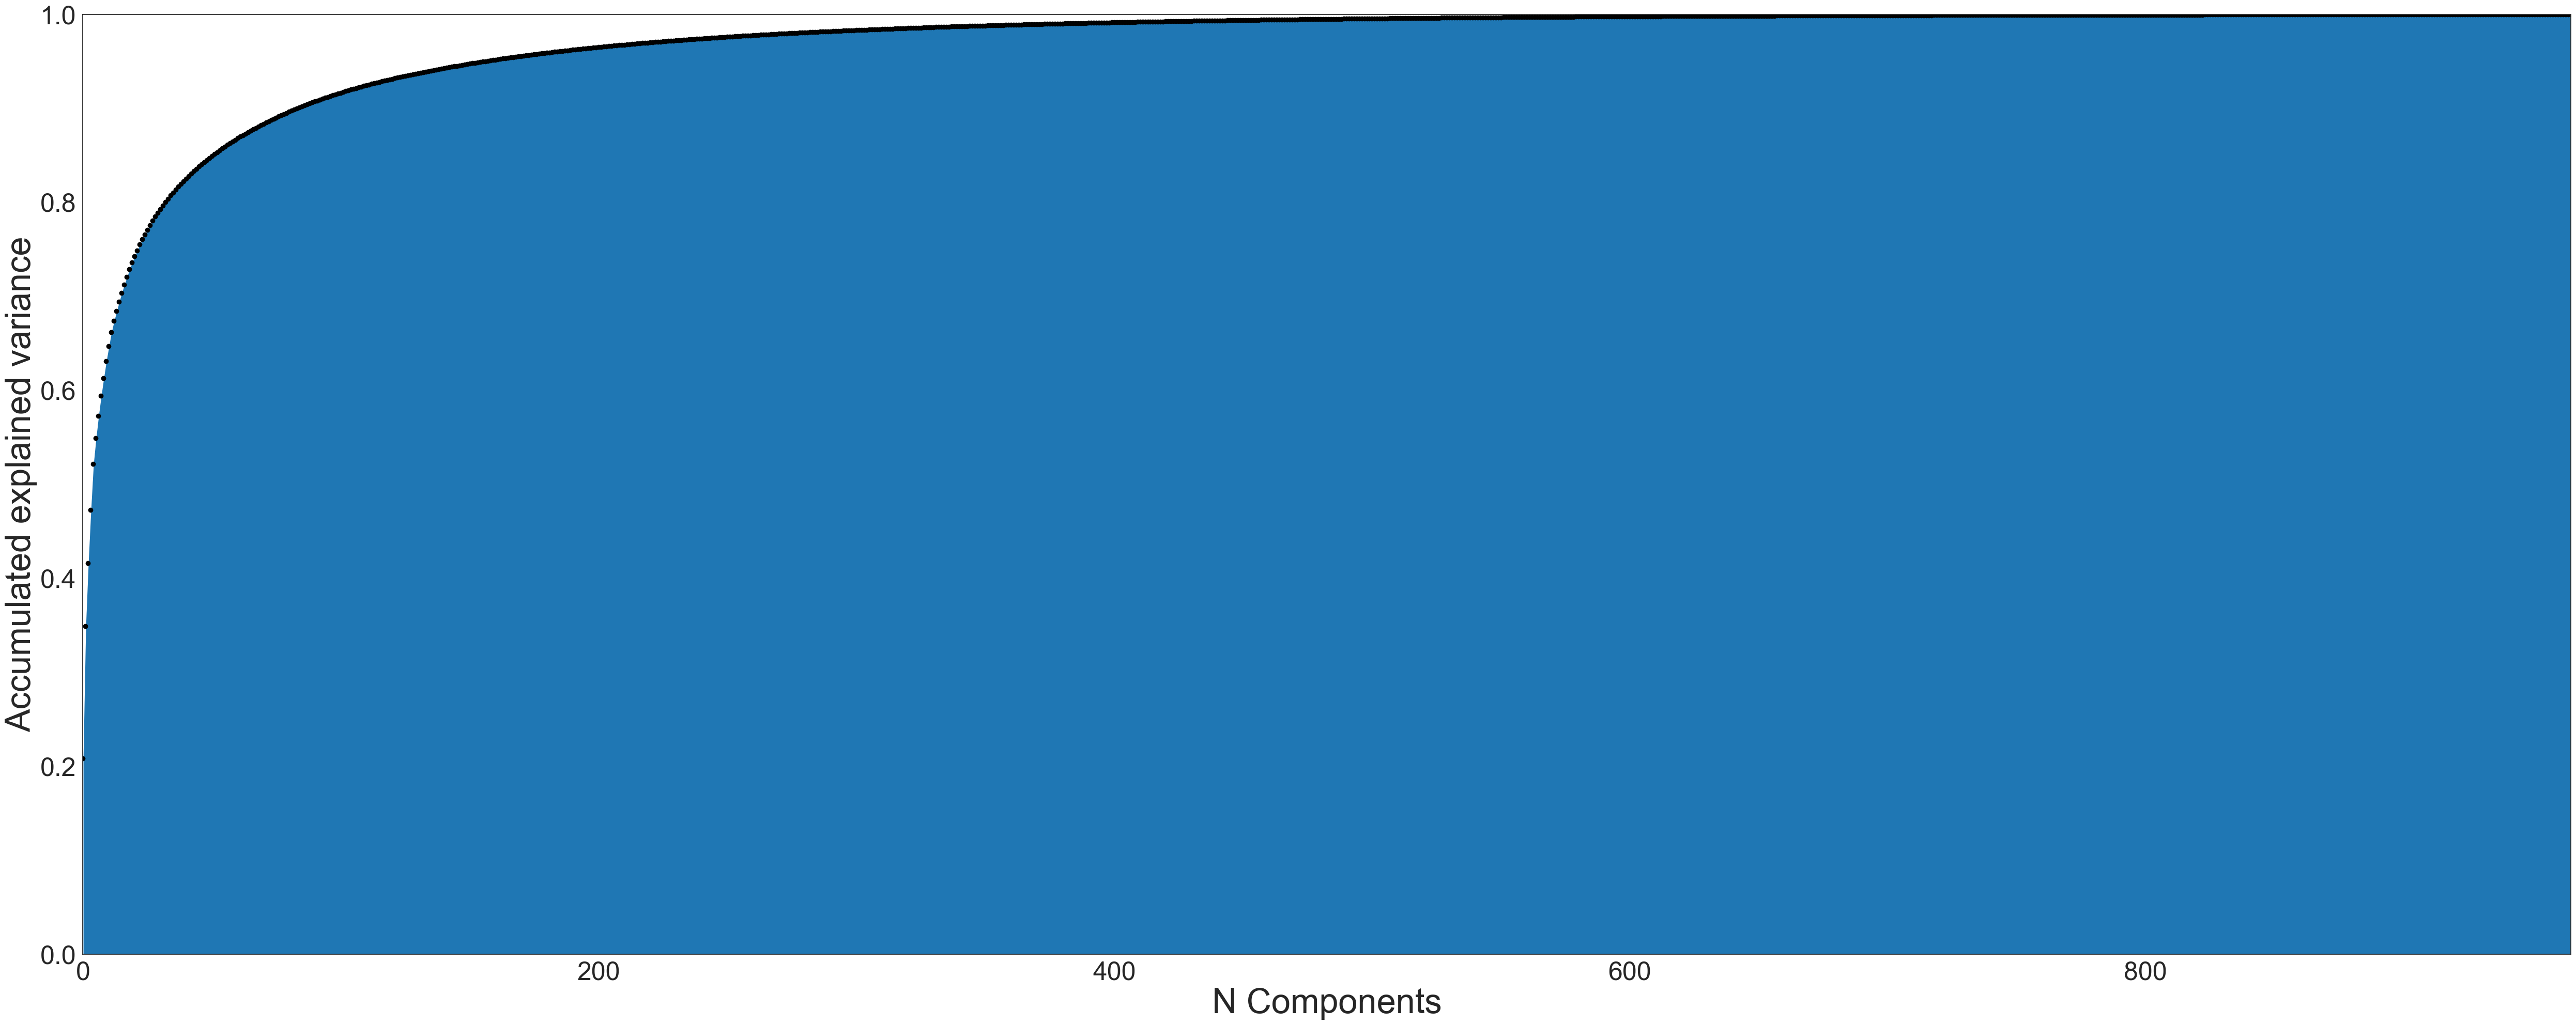

In [78]:
plot_explained_variance(pca)

In [83]:
threshold = 0.6
k = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.6)
f"The first {k} component explain {threshold * 100}% of the variance"

'The first 8 component explain 60.0% of the variance'

So with just 8 components we can already explain 60% of the variance. Since each component is a vector of length n * m, we have to reshape it to the original image size before displaying it.

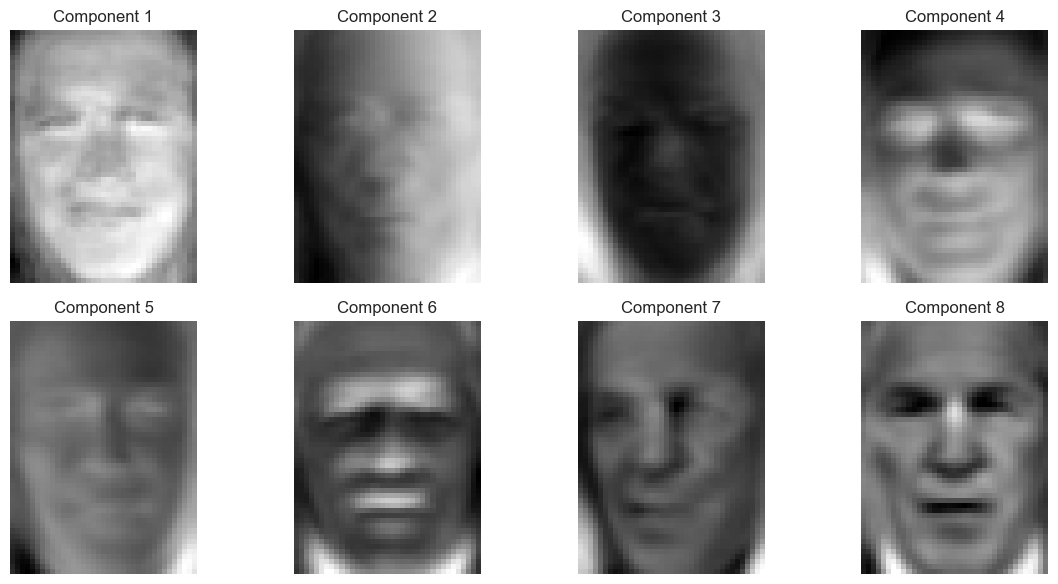

In [97]:
   
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i, (ax, component) in enumerate(zip(axes, pca.components_)):
    ax.imshow(component.reshape(h, w), cmap="gray")
    ax.set_title(f"Component {i+1}")
    ax.axis("off")

# hide the unused 8th subplot
axes[-1].axis("off")

plt.tight_layout()
plt.show()

So clearly recogniseable faces, though it is hard to recognise a specific person from any of them. It is like they have been morphed into each other, which is exactly what the PCA process has done.

Since we've seen earlier from the component graph that about 150 features explain approximately 95% of the variance, we can perform a PCA with 150 components. This will greatly reduce our input data.

In [99]:
pca = PCA(n_components=150, svd_solver="randomized", whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

With this we can transform any of the input faces using only 150 components. Then applying the inverse transform shows what we lose by throwing away 5% of the variance in our original dataset.

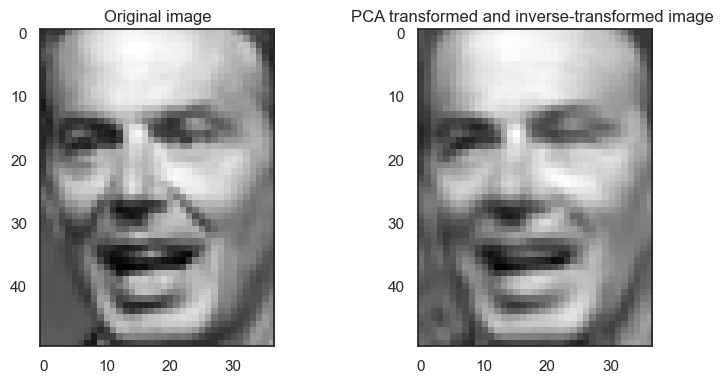

In [100]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(lfw_people.images[1,:,:],cmap='gray')
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(pca.inverse_transform(pca.transform(X[1 ,:].reshape(1, -1))).reshape(h, w),cmap='gray')
plt.title("PCA transformed and inverse-transformed image ") 

plt.tight_layout()
plt.show()

### Fitting a model on dimension-reduced data

Let's try again with the data that we reduced with PCA. The first thing we'll see is that fitting is *much* faster due to the massively reduced size of the data.

In [109]:
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)

clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

Text(47.24999999999999, 0.5, 'Truth Value')

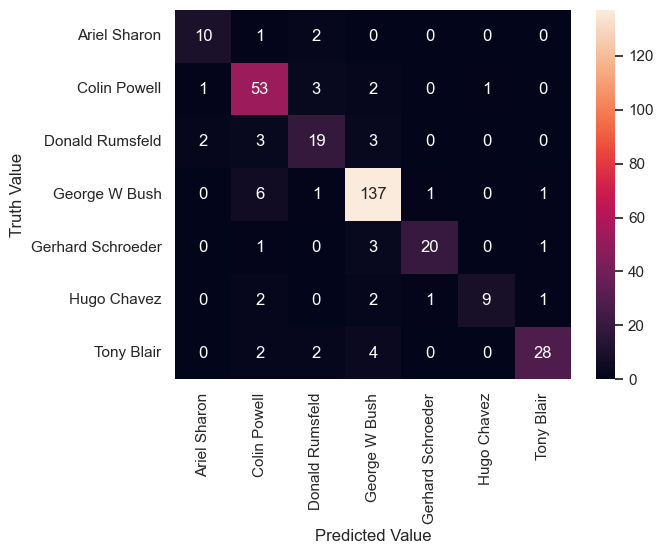

In [110]:
hmap = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    xticklabels=lfw_people.target_names,
    yticklabels=lfw_people.target_names,
    fmt='g'
)
hmap.set_xlabel('Predicted Value')
hmap.set_ylabel('Truth Value')

Where we see that across the board, performance is similar or slightly better. This can also be seen in the classification report below.

The effect of reduction on this small dataset is already significant for the training times. With the performance being better too, this is a strong tool.

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.78      0.88      0.83        60
           2       0.70      0.70      0.70        27
           3       0.91      0.94      0.92       146
           4       0.91      0.80      0.85        25
           5       0.90      0.60      0.72        15
           6       0.90      0.78      0.84        36

    accuracy                           0.86       322
   macro avg       0.84      0.78      0.80       322
weighted avg       0.86      0.86      0.86       322



## PCA on energy prediction data

Finally, we explore the [Applicances Energy Prediction](https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction) dataset.

In [126]:
df = (
    pl.read_csv("./data/energydata_complete.csv")
    .drop("date")
    .with_columns(
        pl.col(pl.Utf8).str.strip_chars()
    )
    .with_columns(
        pl.all().cast(pl.Float64)
    )
    .drop_nans()
)
df.head()

Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
60.0,30.0,19.89,47.596667,19.2,44.79,19.79,44.73,19.0,45.566667,17.166667,55.2,7.026667,84.256667,17.2,41.626667,18.2,48.9,17.033333,45.53,6.6,733.5,92.0,7.0,63.0,5.3,13.275433,13.275433
60.0,30.0,19.89,46.693333,19.2,44.7225,19.79,44.79,19.0,45.9925,17.166667,55.2,6.833333,84.063333,17.2,41.56,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,18.926667,45.89,17.166667,55.09,6.56,83.156667,17.2,41.433333,18.2,48.73,17.0,45.5,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
50.0,40.0,19.89,46.066667,19.2,44.59,19.79,45.0,18.89,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.29,18.1,48.59,17.0,45.4,6.25,733.8,92.0,6.0,51.5,5.0,45.410389,45.410389
60.0,40.0,19.89,46.333333,19.2,44.53,19.79,45.0,18.89,45.53,17.2,55.09,6.366667,84.893333,17.2,41.23,18.1,48.59,17.0,45.4,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [129]:
scaler = StandardScaler()
df = pl.DataFrame(
    scaler.fit_transform(df.to_numpy()),
    df.columns
)
df.head()

Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.367676,3.301264,-1.118645,1.843821,-0.520411,1.073683,-1.235063,1.68613,-0.908217,1.506438,-1.314903,0.47116,-0.145196,0.951798,-1.453646,1.219861,-1.957509,1.141572,-1.217324,0.958136,-0.152647,-2.976328,0.82208,1.207694,2.091596,0.366975,-0.807974,-0.807974
-0.367676,3.301264,-1.118645,1.616807,-0.520411,1.057097,-1.235063,1.704566,-0.908217,1.604528,-1.314903,0.47116,-0.176941,0.945592,-1.453646,1.206825,-1.957509,1.134554,-1.200778,0.965363,-0.174588,-2.962813,0.82208,1.071703,1.766584,0.343135,-0.44024,-0.44024
-0.465215,3.301264,-1.118645,1.517959,-0.520411,1.03355,-1.235063,1.748608,-0.944115,1.580918,-1.314903,0.458968,-0.221822,0.916484,-1.453646,1.182057,-1.957509,1.109032,-1.233869,0.95091,-0.196529,-2.949298,0.82208,0.935713,1.441572,0.319294,0.252109,0.252109
-0.465215,4.561378,-1.118645,1.459321,-0.520411,1.02454,-1.235063,1.769092,-0.962063,1.542526,-1.314903,0.458968,-0.242621,0.925045,-1.485243,1.15403,-2.008631,1.082233,-1.233869,0.926821,-0.21847,-2.935783,0.82208,0.799723,1.116559,0.295454,1.408801,1.408801
-0.367676,4.561378,-1.118645,1.526336,-0.520411,1.009797,-1.235063,1.769092,-0.962063,1.497991,-1.296832,0.458968,-0.253567,0.972238,-1.453646,1.142298,-2.008631,1.082233,-1.233869,0.926821,-0.240411,-2.922268,0.82208,0.663733,0.791547,0.271613,-1.028122,-1.028122


In [146]:
pca = PCA()
pca.fit(df)

threshold = 0.95
k = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), threshold)

f"More than {threshold*100:.0f}% of the variance can be explained with {k} PCA components."

'More than 95% of the variance can be explained with 11 PCA components.'

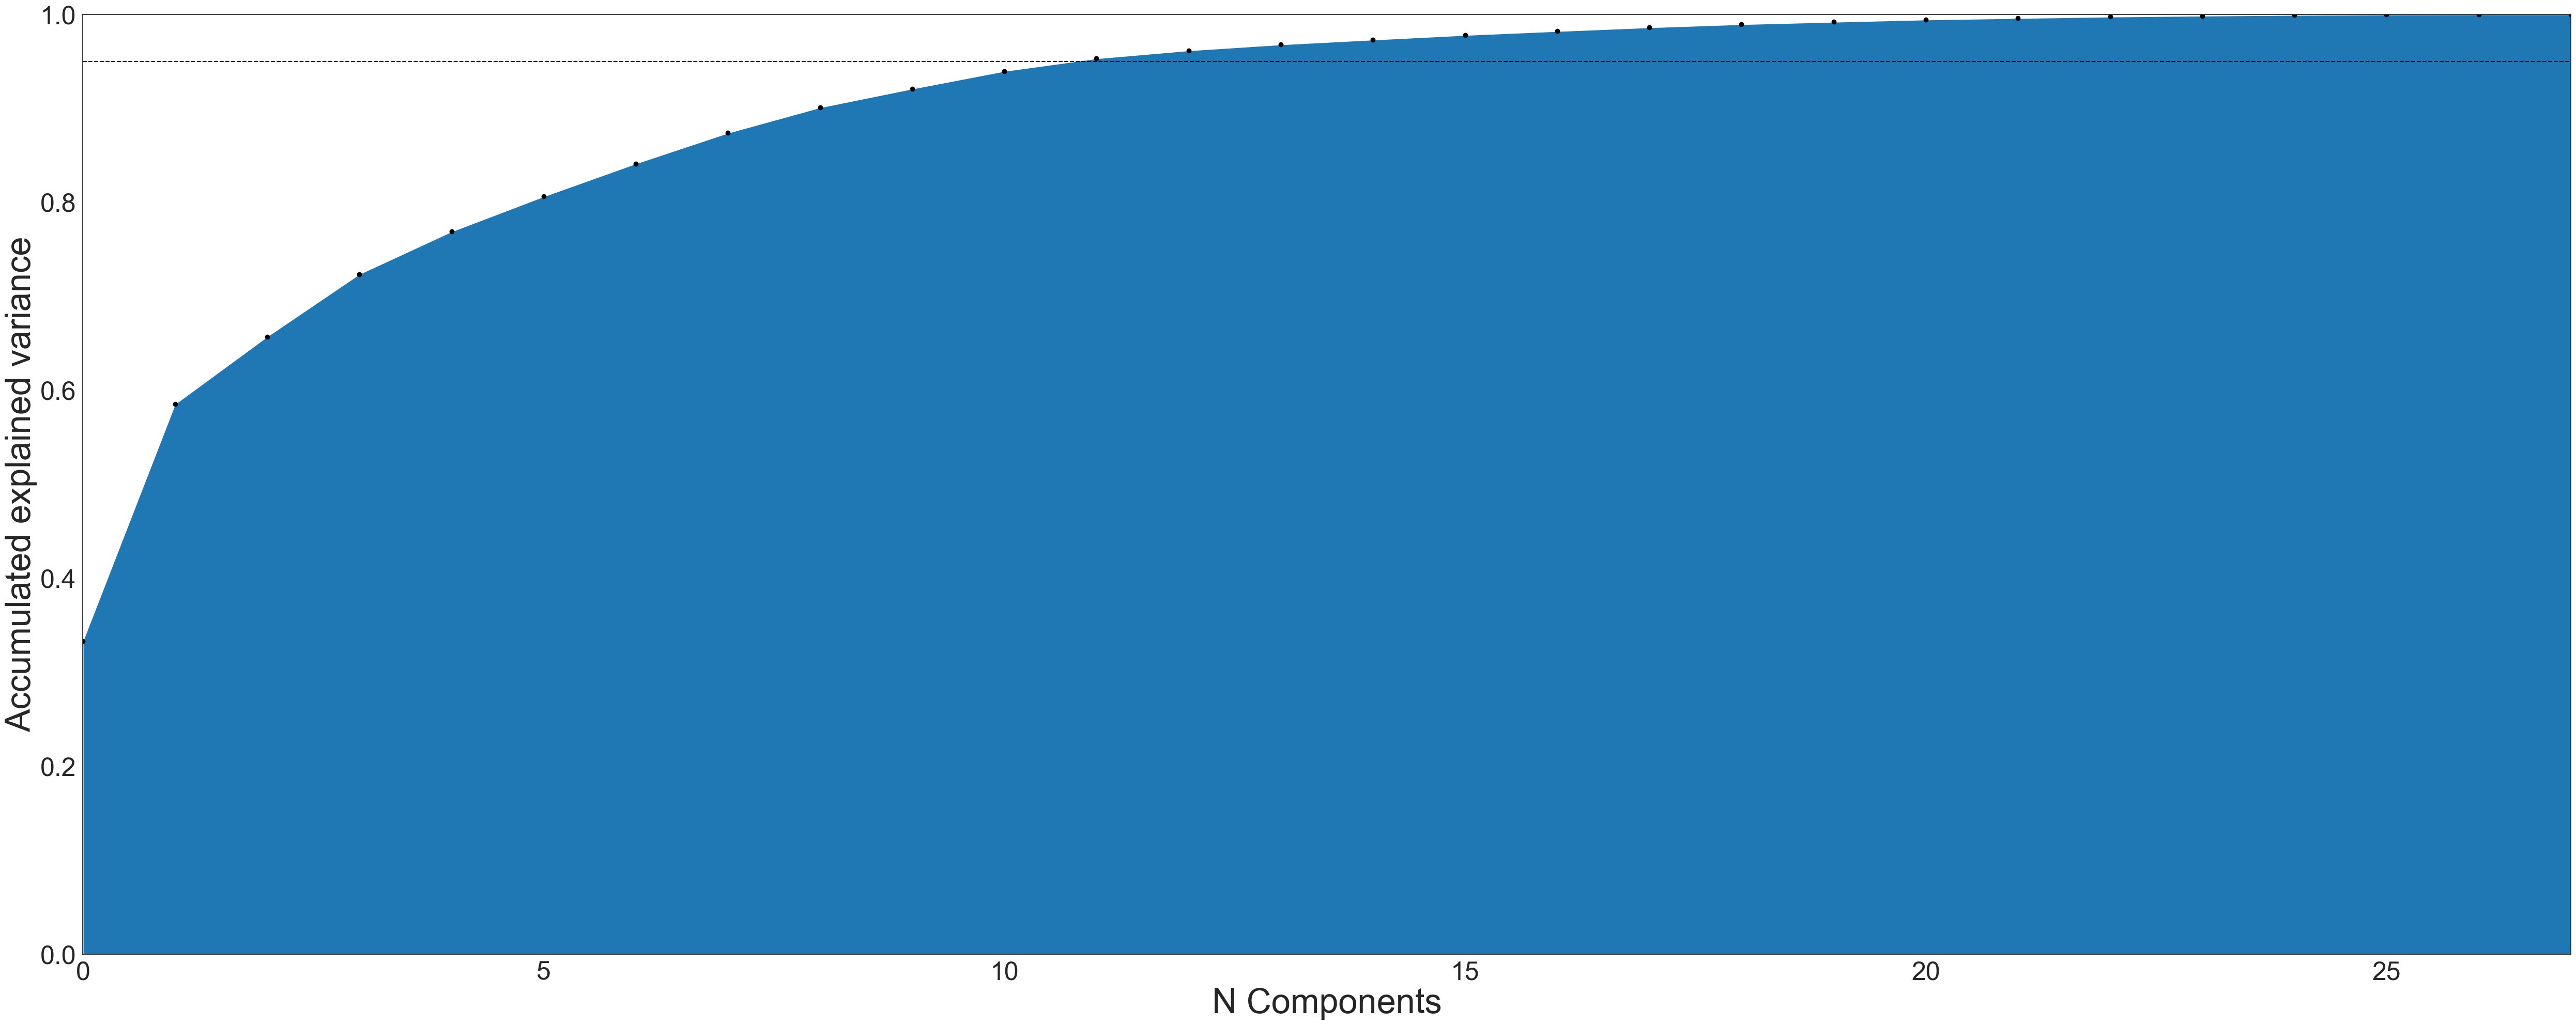

In [147]:
plot_explained_variance(pca, threshold=threshold)

In [155]:
pca = PCA(n_components=k).fit(df)
df_transformed = pca.transform(df)

In [157]:
pl.DataFrame(
    df_transformed, 
    schema = [f'Component {i}' for i in range(df_transformed.shape[1])]
).head()

Component 0,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-2.922039,4.688402,-1.548784,1.200384,1.953325,-0.37292,2.529788,0.640358,2.475223,-0.748954,-1.448401
-2.940551,4.617382,-1.026564,1.273485,1.958929,-0.495274,2.237205,0.583417,2.463552,-0.854024,-1.437129
-2.983922,4.532971,-0.057812,1.455761,1.925351,-0.626959,1.941323,0.559629,2.499994,-0.9498,-1.460569
-3.07454,4.511345,1.50316,1.955986,2.80353,-0.560489,1.565011,0.474951,3.320774,-1.015321,-1.598426
-3.050297,4.4862,-1.798191,0.97651,2.843927,-0.700518,1.271911,0.287486,3.287537,-1.118611,-1.607082
